<div style="border-radius: 10px; border: #DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size: 100%; text-align: left">
<h3 align="left"><font color='#3498DB'> Chapter9</font></h3>

このノートブックではPyMCでMCMCを実行する方法について紹介しています。  
元のノートブックは以下です。  
https://github.com/pymc-devs/pymc-resources/blob/main/Rethinking_2/Chp_09.ipynb

In [10]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from scipy import stats

warnings.simplefilter(action="ignore", category=FutureWarning)
pd.set_option("mode.chained_assignment", None)

In [57]:
%config Inline.figure_format = 'retina'
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89 
# sets default credible interval used by arviz

In [23]:
num_weeks = int(1e5)
positions = np.zeros(num_weeks)
current =10
for i in range(num_weeks):
    positions[i] = current
    proposal = current + np.random.choice([-1,1])
    if proposal < 1:
        proposal =10
    if proposal > 10:
        proposal =1
    prob_move = proposal / current
    if np.random.uniform() < prob_move:
        current = proposal

<div style="border-radius: 10px; border: #DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size: 95%; text-align: left">
<h3 align="left"><font color='#3498DB'>🦄 Notes: メトロポリスアルゴリズムの例</font></h3>

このコードの背景は教科書を参照してください。
ざっくり言うと、環状に並んだ海上の10個の島の巡り方をコイントスで決めています。
* 一週間が過ぎるごとにforループを回す。
* positions[i] = currentでは現在の位置をpositionに格納している。  
  (iはnum_weeksの数だけある)  
* コイントスによって提案される島の番号はproposalになる。
* ただし、島は環状に順番に並んでいるので、島の番号がマイナスになれば10であり、
  10以上であれば番号1の島に行くことにする。
* 移動確率prob_moveをproposal / currentとして定める。
* prob_moveがランダムな0~1の数値より大きい場合、移動する。

<div style="border-radius: 10px; border: #DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size: 95%; text-align: left">
<h3 align="left"><font color='#3498DB'>🦄 Notes:簡潔なコード</font></h3>

* if文をより簡潔に以下のように書ける。
  ```
   # Wrap around if proposal is out of [1, 10]  
     if proposal < 1: proposal = 10  
     if proposal > 10: proposal = 1
   ```

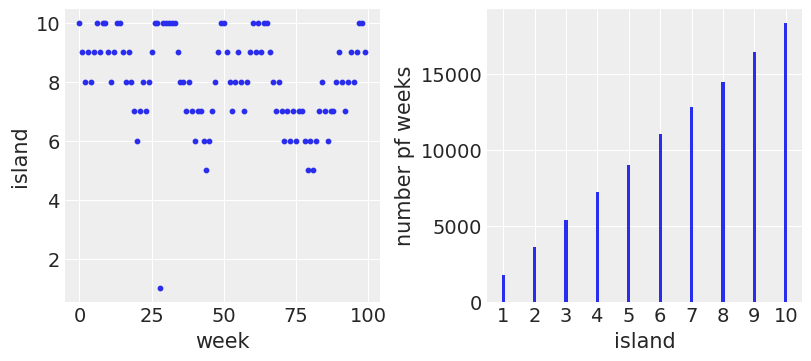

In [55]:
_, axs = plt.subplots(1, 2, figsize=[8, 3.5], constrained_layout=True)

ax0, ax1 = axs

nplot = 100
ax0.scatter(range(nplot), positions[:nplot], s=10)
ax0.set_ylabel("island")
ax0.set_xlabel("week")

counts, _ = np.histogram(positions, bins=10)
ax1.bar(range(10), counts, width=0.1)
ax1.set_ylabel("number pf weeks")
ax1.set_xlabel("island")
ax1.set_xticks(range(10))
ax1.set_xticklabels(range(1, 11));

<div style="border-radius: 10px; border: #DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size: 95%; text-align: left">
<h3 align="left"><font color='#3498DB'>🦄 Notes: 図による表現</font></h3>

* constrained_layout=Trueは自動的な配置を行い、サブプロットが重ならないようにする。
* ax0, ax1 = axs は、axsから取得したサブプロットオブジェクトを ax0 と ax1 にそれぞれ代入する。
* positionsリストの最初の100個をプロットする。
* scatter()の引数のsはデータポイントの点のサイズ。
* _, axs = plt.subplots()とax0, ax1 = axsでアンパック代入を実行している。

Text(0, 0.5, 'Density')

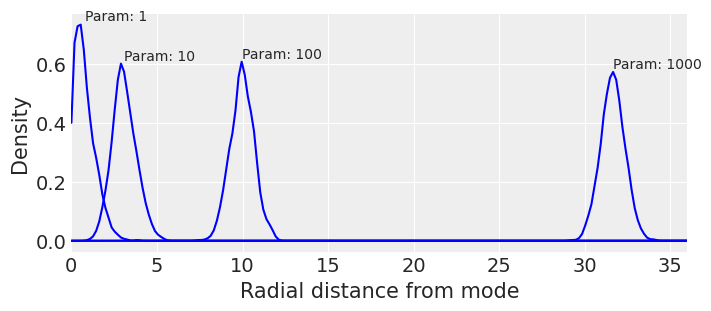

In [58]:
def rad_dist(Y):
    return np.sqrt(np.sum(Y**2))

fig, ax = plt.subplots(1, 1, figsize=[7,3])
xvar = np.linspace(0, 36, 200)

for D in [1, 10, 100, 1000]:
    T = int(1e3)
    Y = stats.multivariate_normal(np.zeros(D), np.identity(D)).rvs(T)
    
    Rd = list(map(rad_dist, Y))

    kde = stats.gaussian_kde(Rd)
    yvar = kde(xvar)
    ax.plot(xvar, yvar, color="b")

    ax.text(np.mean(Rd), np.max(yvar)*1.02, f"Param: {D}")

ax.set_xlim(0, 36)
ax.set_xlabel("Radial distance from mode")
ax.set_ylabel("Density")

<div style="border-radius: 10px; border: #DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size: 95%; text-align: left">
<h3 align="left"><font color='#3498DB'>🦄 Notes: パラメータ数と次元の呪い</font></h3>

* 個々のパラメータを個別のステップでサンプリングする任意のマルコフチェーンは、
  パラメータが多くなると行き詰る。
* パラメータ数が多くなるほどモードはサンプリングしたい値から離れる。
* 横軸が0の点がモード。

In [26]:
def calc_U(x, y, q, a=0, b=1, k=0, d=1):
    muy, mux =q

    U = (
         np.sum(stats.norm.logpdf(y, loc=muy, scale=1))
         + np.sum(stats.norm.logpdf(x, loc=mux, scale=1))
         + stats.norm.logpdf(muy, loc=a, scale=b)
         + stats.norm.logpdf(mux, loc=k, scale=d)
    )

    return -U

In [27]:
# 勾配関数
# Uをqについて偏微分したベクトルが必要

def calc_U_gradient(x, y, q, a=0, b=1, k=0, d=1):
    muy, mux =q

    G1 = np.sum(y - muy) + (a - muy) / b**2  #dU/dmuy
    G2 = np.sum(x - mux) + (k - mux) / b**2  #dU/dmux

    return np.array([-G1, -G2])
    

<div style="border-radius: 10px; border: #DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size: 95%; text-align: left">
<h3 align="left"><font color='#3498DB'>🦄 Notes: no-U-turn サンプラー(NUTS)の実装</font></h3>

* U関数は対数事後確率を表現する
* 勾配関数は偏微分を行う
* リスト[]をNumpy配列に変換

Code 9.7では以下の関数を使用する。

In [36]:
def HMC2(U, grad_U, epsilon, L, current_q, x, y):
    q = current_q  
    p = np.random.normal(loc=0, scale=1, size=len(q))  # ランダムなフリック - pは運動量
    current_p = p
    # 初めに運動量のハーフステップを行う
    p -= epsilon * grad_U(x, y, q) / 2
    # ブックキーピングの初期化 - 経路を保存
    qtraj = np.full((L+1, len(q)), np.nan)
    ptraj = qtraj.copy()
    qtraj[0,:] = current_q
    ptraj[0,:] = p

    # Code 9.9
    # 位置と運動量の交互のフルステップ
    for i in range(L):
        q += epsilon * p #位置のフルステップ
        qtraj[i + 1, :] =q
        # 経路の終わり以外で、運動量のフルステップを行う。
        if i != L - 1:
            p -= epsilon * grad_U(x, y, q)
            ptraj[i + 1, :] = p

    # 終わりに運動量のハーフステップを行う
    p -= epsilon * grad_U(x, y, q) / 2
    ptraj[L, :] = p
    # 提案を対称的にするために、経路の終わりで運動量を負にする
    p *= -1
    # 経路の始まりと終わりでポテンシャルエネルギーと運動エネルギーを評価
    current_U = U(x, y, current_q)
    current_K = np.sum(current_p**2) / 2
    proposed_U = U(x, y, q)
    proposed_K = np.sum(p**2) / 2
    # 経路の終わりの状態を受け入れるか拒否し
    # 経路の終わりの位置または初期位置を返す
    accept = False
    if np.random.uniform() < np.exp(current_U - proposed_U + current_U - proposed_K):
        new_q = q #採択
        accept = True
    else:
        new_q = current_q #棄却
        
    return dict(q=new_q, traj=qtraj, ptraj=ptraj, accept=accept)

<div style="border-radius: 10px; border: #DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size: 95%; text-align: left">
<h3 align="left"><font color='#3498DB'>🦄 Notes: </font></h3>

* qtraj = np.full((L+1, len(q)), np.nan)では、多次元配列 qtraj を生成し、その要素を NaNで初期化している。
* np.full()は、指定された形状と初期値で配列を生成する関数。
* qtraj[0, :] は qtraj 配列の最初の行で、そのすべての列を含む部分配列のこと。
* q += epsilon * pは、q = q + epsilon * pと同じ操作。
* if i != L - 1 は、iがL-1ではない場合のこと。
* p *= -1は、p = p * -1と同じ操作。
* current_p**2は、current_pを2乗する操作のこと。

### Code 9.7

以下コードは、図9.6の上段の両方のパネルを生成するために、コード9.7を拡張したものです。

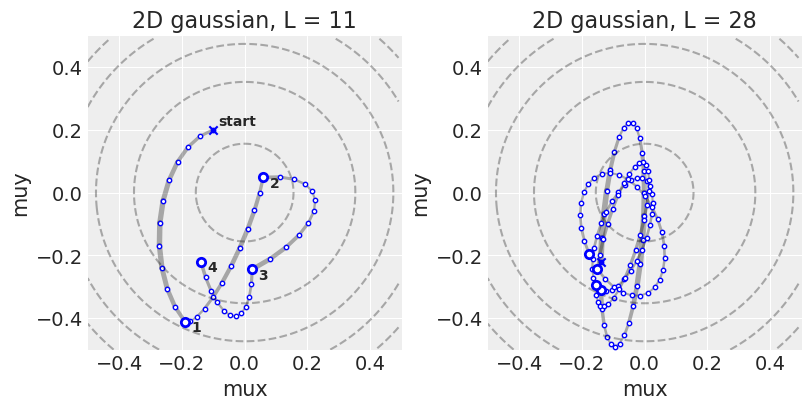

In [59]:
np.random.seed(42)

# テストデータ
real = stats.multivariate_normal([0, 0], np.identity(2))
x, y = real.rvs(50).T

Q = {}
Q["q"] = np.array([-0.1, 0.2])
pr = 0.5
step = 0.03
# L = 11 # Uターン用には0.03 / 28、動作する例では11
n_samples = 4

_, axs = plt.subplots(1, 2, figsize=[8, 6], constrained_layout=True)

for L, ax in zip([11, 28], axs):
    ax.scatter(*Q["q"], color="b", marker="x", zorder=3)
    if L == 11:
        ax.text(*Q["q"] + 0.015, "start", weight="bold")
    for i in range(n_samples):
        Q = HMC2(calc_U, calc_U_gradient, step, L, Q["q"], x, y)
        ax.scatter(*Q["q"], color="w", marker="o", edgecolor="b", lw=2, zorder=3)
        if n_samples < 10:
            for j in range(L):
                KO = np.sum(Q["ptraj"][j, :] **2) /2 # 運動エネルギー
                ax.plot(
                    Q["traj"][j : j + 2, 0],
                    Q["traj"][j : j + 2, 1],
                    color="k",
                    lw=1 + 1 *KO,
                    alpha=0.3,
                    zorder=1,
                )
            ax.scatter(*Q["traj"].T, facecolor="w", edgecolor="b", lw=1, zorder=2, s=10)
            if L ==11:
                ax.text(*Q["q"] + [0.02, -0.03], f"{i+1}", weight="bold")
                        
    ax.set_title(f"2D gaussian, L = {L}")
    ax.set_xlabel("mux")
    ax.set_ylabel("muy")

    #上記で定義された実際の確率に基づいて背景の輪郭線を描画
    ax.set_xlim(-pr, pr)
    ax.set_ylim(-pr, pr)
    xs, ys = np.mgrid[-pr:pr:0.01, -pr:pr:0.01]
    p = real.logpdf(np.vstack([xs.flat, ys.flat]).T).reshape(xs.shape)
    ax.contour(xs, ys, p, 4, colors=[(0,0,0,0.3)])
    ax.set_aspect(1);

<div style="border-radius: 10px; border: #DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size: 95%; text-align: left">
<h3 align="left"><font color='#3498DB'>🦄 Notes: </font></h3>

* {} はPythonの中で辞書を作成するための記法。辞書は、キー（key）とそれに対応する値（value）のペアを格納するデータ構造。  
  (辞書は内部的にハッシュ表(ハッシュテーブル)と呼ばれるリストを持つ。ハッシュ値(その格納先)は重複する可能性もある。)  
  (辞書のキーはハッシュ値を算出可能な型でないといけない(hashable)。)　　
* ax.scatter(*Q["q"], color="b", marker="x", zorder=3)は、ax.scatter(Q["q"][0], Q["q"][1], color="b", marker="x", zorder=3)と同じ。